## Import packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

## Importing the dataset

In [8]:
url = 'https://raw.githubusercontent.com/engyssimo/MLProjectNucphys/main/Project2/Data/weatherAUS.csv'
df = pd.read_csv(url)


#Convert date to year, month, day
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis = 1, inplace = True)
df.head()

# Need to find again the object variables
object_var = [i for i in df.columns if df[i].dtype=='O']
numerical_var = [i for i in df.columns if df[i].dtype!='O']

# Preprocessing

## Imputation of the NaN values

In [9]:
# display(df[numerical_var].isnull().sum())
# display(df[object_var].isnull().sum())

for col in numerical_var:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True)

for col in object_var:
    common = df[col].mode()[0]         # returns the most frequent value
    df[col].fillna(common, inplace=True)


display(df[numerical_var].isnull().sum())
display(df[object_var].isnull().sum())    # To check that all missing values are filled in

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Year             0
Month            0
Day              0
dtype: int64

Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

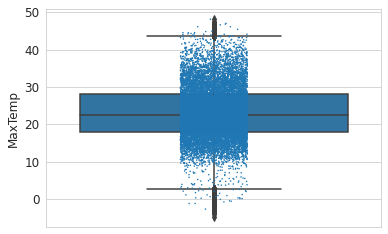

In [10]:
# Boxplot with Seaborn
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))
matplotlib.rcParams.update({'font.size': 12})
ax = sns.boxplot(y='MaxTemp',data=df)
ax = sns.stripplot(y="MaxTemp",data=df.sample(frac=0.1),size=1.5)
plt.savefig("box_plot.png", bbox_inches='tight')

## Encoding of categorical variables

In [14]:
categorical_or_integer_encoding = True #True for categorical, False for integer

# Encoding the variable RainToday -> 1 and 0 representing Rain and No rain (Which is which?)
# Encoding is an addition of variables


def integer_encoding(feature_name):
    ''' 
    This function takes feature name as a parameter and returns mapping dictionary to replace categorical data with numerical data. 
    '''
    mapping = {}
    values = list(df[feature_name].unique())
    for idx in range(len(values)):
        mapping[values[idx]] = idx
    return mapping

#Excluding the outliers

features_with_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for feature in features_with_outliers:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature]<lower_limit,feature] = lower_limit
    df.loc[df[feature]>upper_limit,feature] = upper_limit



#choose encoding
if(categorical_or_integer_encoding):

  #Replace Yes with 1 and No with 0
    df['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)
    df['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)
    df.head()
  #Replace the columns with the one-hot encoded variables
    df = pd.concat([df[numerical_var],
                     pd.get_dummies(df.Location),
                     pd.get_dummies(df.WindGustDir,prefix="WindGustDir"),
                     pd.get_dummies(df.WindDir9am,prefix="WindDir9am"),
                     pd.get_dummies(df.WindDir3pm,prefix="WindDir3pm"),
                     df["RainToday"], 
                     df["RainTomorrow"]], axis=1)
    display(df)

else:
  #Here we are doing integer encoding 

  #Replace Yes with 1 and No with 0
    df['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)
    df['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)

  #Here we are using the encoding function defined previously 
    df['WindGustDir'].replace(integer_encoding('WindGustDir'), inplace = True)
    df['WindDir9am'].replace(integer_encoding('WindDir9am'), inplace = True)
    df['WindDir3pm'].replace(integer_encoding('WindDir3pm'), inplace = True)
    df['Location'].replace(integer_encoding('Location'), inplace = True)
    df.head()


X = df.drop(["RainTomorrow"], axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0          13.4     22.9       0.6          4.8       8.4           44.0   
1           7.4     25.1       0.0          4.8       8.4           44.0   
2          12.9     25.7       0.0          4.8       8.4           46.0   
3           9.2     28.0       0.0          4.8       8.4           24.0   
4          17.5     32.3       1.0          4.8       8.4           41.0   
...         ...      ...       ...          ...       ...            ...   
145455      2.8     23.4       0.0          4.8       8.4           31.0   
145456      3.6     25.3       0.0          4.8       8.4           22.0   
145457      5.4     26.9       0.0          4.8       8.4           37.0   
145458      7.8     27.0       0.0          4.8       8.4           28.0   
145459     14.9     22.6       0.0          4.8       8.4           39.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
0               20.0          24.0         71.0         22.0  ...   
1                4.0          22.0         44.0         25.0  ...   
2               19.0          26.0         38.0         30.0  ...   
3               11.0           9.0         45.0         16.0  ...   
4                7.0          20.0         82.0         33.0  ...   
...              ...           ...          ...          ...  ...   
145455          13.0          11.0         51.0         24.0  ...   
145456          13.0           9.0         56.0         21.0  ...   
145457           9.0           9.0         53.0         24.0  ...   
145458          13.0           7.0         51.0         24.0  ...   
145459          17.0          17.0         62.0         36.0  ...   

        WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
0                  0              0               0               0   
1                  0              0               0               0   
2                  0              0               0               0   
3                  0              0               0               0   
4                  0              0               0               0   
...              ...            ...             ...             ...   
145455             0              0               0               0   
145456             0              0               0               0   
145457             0              0               0               0   
145458             0              0               0               0   
145459             0              0               0               0   

        WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  \
0                   0             0               1               0   
1                   0             0               0               1   
2                   0             0               0               1   
3                   0             0               0               0   
4                   0             0               0               0   
...               ...           ...             ...             ...   
145455              0             0               0               0   
145456              0             0               0               0   
145457              0             0               1               0   
145458              0             0               0               0   
145459              0             0               0               0   

        RainToday  RainTomorrow  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  
...           ...           ...  
145455          0             0  
145456          0             0  
145457          0             0  
145458          0             0  
145459          0             0  

[145460 rows x 118 columns]

## Scaling of the data

In [15]:
columns = X_train.columns
#scaler = MinMaxScaler()       # Here we use MinMax scaler, but we could use Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# NOte: when we do the transform, we loose the column and the dataframe, therefore we need to create it again
X_train = pd.DataFrame(X_train, columns = [columns])
X_test = pd.DataFrame(X_test, columns = [columns])

X_train.head()

MinTemp   MaxTemp  Rainfall Evaporation  Sunshine WindGustSpeed  \
0  1.038333  0.069783 -0.299833    0.173393 -0.247128      1.013193   
1 -0.454098  0.112250 -0.299833   -1.754514  1.056451      0.684727   
2 -0.202741 -0.142553  1.670508   -1.754514  0.585714     -1.121842   
3  1.116882  0.947437 -0.628223    1.550469  1.092661      0.274143   
4  0.551329 -0.793716  1.834703    0.035685  0.151188     -1.614542   

  WindSpeed9am WindSpeed3pm Humidity9am Humidity3pm  ... WindDir3pm_NW  \
0     1.992888     1.112792    0.267841    1.046686  ...     -0.250675   
1    -0.110269     0.639069    0.267841    0.166056  ...     -0.250675   
2    -1.629217    -0.900532    0.857213   -0.225335  ...     -0.250675   
3     1.408678    -0.189947   -1.339537   -0.714574  ...     -0.250675   
4    -0.343954    -0.663671    1.660902    2.367631  ...     -0.250675   

  WindDir3pm_S WindDir3pm_SE WindDir3pm_SSE WindDir3pm_SSW WindDir3pm_SW  \
0    -0.271064     -0.340185       -0.26415      -0.243688     -0.263199   
1    -0.271064     -0.340185       -0.26415      -0.243688     -0.263199   
2    -0.271064     -0.340185       -0.26415      -0.243688      3.799404   
3    -0.271064     -0.340185       -0.26415      -0.243688     -0.263199   
4    -0.271064     -0.340185       -0.26415      -0.243688     -0.263199   

  WindDir3pm_W WindDir3pm_WNW WindDir3pm_WSW RainToday  
0    -0.272923      -0.253336      -0.263572 -0.530540  
1    -0.272923      -0.253336      -0.263572 -0.530540  
2    -0.272923      -0.253336      -0.263572  1.884871  
3    -0.272923      -0.253336      -0.263572 -0.530540  
4    -0.272923      -0.253336      -0.263572  1.884871  

[5 rows x 117 columns]

In [16]:
#Tried with PCA, but performance does not improve

# pca = PCA(n_components=.95)
# pca.fit(X_train)
# X_train = pd.DataFrame(pca.transform(X_train))
# X_test = pd.DataFrame(pca.transform(X_test))
# X_train.head()

# Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)

classifier.fit(X_train, y_train)
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

y_test_lr = classifier.predict_proba(X_test)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_test_lr[:,1])

print("Model accuracy test score:{0:0.4f}".format(accuracy_score(y_test,y_pred_test)))
print("Model accuracy train score:{0:0.4f}".format(accuracy_score(y_train,y_pred_train)))

Model accuracy test score:0.8488
Model accuracy train score:0.8484


# Decision tree

In [21]:
# No option for max_depth: splitting until leaves contain 1 only element -> This causes heavy overfitting
SimpleTree = DecisionTreeClassifier(random_state=1,max_depth=9)


# Fit of the model
# accuracy = cross_validate(SimpleTree,X_test,y_test,cv=10)['test_score']
# print(accuracy)
# accuracy.mean()
SimpleTree.fit(X_train, y_train)

#ROC
y_test_tree = SimpleTree.predict_proba(X_test)
fpr_tree, tpr_tree, thresholds = roc_curve(y_test, y_test_tree[:,1])


#Predict results

y_pred_test = SimpleTree.predict(X_test)
# y_pred_test
# SimpleTree.predict_proba(X_test)[:,0] # 1 probability of no rain, 0 probability of rain

#We need to check the accuracy score

print("Model accuracy test score:{0:0.4f}".format(accuracy_score(y_test,y_pred_test)))
# We need to compare it to the training test score, to check for overfitting or underfitting

y_pred_train = SimpleTree.predict(X_train)

print("Model accuracy train score:{0:0.4f}".format(accuracy_score(y_train,y_pred_train)))

Model accuracy test score:0.8415
Model accuracy train score:0.8558


Varying max_depth of the single tree

Model accuracy test score:0.8169
Model accuracy train score:0.8156
Model accuracy test score:0.8232
Model accuracy train score:0.8243
Model accuracy test score:0.8299
Model accuracy train score:0.8307
Model accuracy test score:0.8332
Model accuracy train score:0.8350
Model accuracy test score:0.8367
Model accuracy train score:0.8388
Model accuracy test score:0.8381
Model accuracy train score:0.8414
Model accuracy test score:0.8406
Model accuracy train score:0.8461
Model accuracy test score:0.8403
Model accuracy train score:0.8499
Model accuracy test score:0.8415
Model accuracy train score:0.8558
Model accuracy test score:0.8395
Model accuracy train score:0.8638
Model accuracy test score:0.8374
Model accuracy train score:0.8725
Model accuracy test score:0.8347
Model accuracy train score:0.8833
Model accuracy test score:0.8332
Model accuracy train score:0.8946
Model accuracy test score:0.8293
Model accuracy train score:0.9067
Model accuracy test score:0.8246
Model accuracy train score:0.

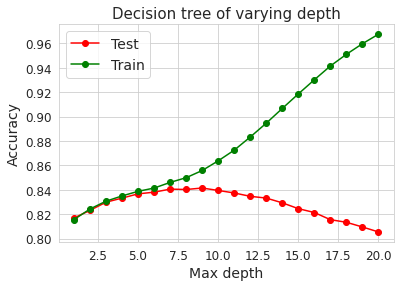

In [20]:
max_max_depth = 20

test_acc = np.zeros(max_max_depth)
train_acc = np.zeros(max_max_depth)

#changing max_depth as the complexity of the tree
for d in range(max_max_depth):
  SimpleTree = DecisionTreeClassifier(max_depth=d+1,random_state=1)
  SimpleTree.fit(X_train, y_train)
  y_pred_test = SimpleTree.predict(X_test)
  test_acc[d] = accuracy_score(y_test,y_pred_test)
  print("Model accuracy test score:{0:0.4f}".format(test_acc[d]))
  y_pred_train = SimpleTree.predict(X_train)
  train_acc[d] = accuracy_score(y_train,y_pred_train)
  print("Model accuracy train score:{0:0.4f}".format(train_acc[d]))

print("Maximum test accuracy: {:.4f} ".format(np.max(test_acc)))
print("For maximum depth: ",np.arange(1,max_max_depth+1)[np.argmax(test_acc)])
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.title("Decision tree of varying depth",fontsize=15)
plt.plot(range(1,max_max_depth+1),test_acc,"o-",color="red",label="Test")
plt.plot(range(1,max_max_depth+1),train_acc,"o-",color="green",label="Train")
plt.xlabel("Max depth",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.legend(fontsize=14)
plt.savefig("Pictures/tree_depth.png", bbox_inches='tight')

# Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier # import the package
from sklearn.tree import DecisionTreeClassifier # import the package

Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1), bootstrap=True, n_jobs=-1, random_state=1,)
#Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=1000, max_samples=200, bootstrap=True, n_jobs=-1, random_state=1)

# Fit of the model

Bag_model.fit(X_train, y_train)

#Predict results
y_pred_test = Bag_model.predict(X_test)
y_pred_test
Bag_model.predict_proba(X_test)[:,0] # 1 probability of no rain, 0 probability of rain

#We need to check the accuracy score
from sklearn.metrics import accuracy_score

print("Model accuracy test score:{0:0.4f}".format(accuracy_score(y_test,y_pred_test)))
# We need to compare it to the training test score, to check for overfitting or underfitting

y_pred_train = Bag_model.predict(X_train)

print("Model accuracy train score:{0:0.4f}".format(accuracy_score(y_train,y_pred_train)))


#
# Adjusting number of trees in the ensemble and fraction of points for the bootstrap
#


n_est = 4
n_fracs = 3

test_acc = np.zeros((n_est,n_fracs))
train_acc = np.zeros((n_est,n_fracs))

max_estimators = 150
max_max_samples = 0.7
i = 0

range_samples = np.arange(0.4,max_max_samples,0.1)

for n_es in range(50 ,max_estimators, 25):
  j = 0
  for sam in range_samples:
    Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=n_es, max_samples=sam, bootstrap=True, n_jobs=-1, random_state=1)
    Bag_model.fit(X_train, y_train)
    y_pred_test = Bag_model.predict(X_test)
    test_acc[i,j] = accuracy_score(y_test,y_pred_test)
    print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,sam,test_acc[i,j]))
    y_pred_train = Bag_model.predict(X_train)
    train_acc[i,j] = accuracy_score(y_train,y_pred_train)
    print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,sam,train_acc[i,j]))
    j+=1
  plt.figure(figsize=(5,4))
  plt.title("n_estimators = {}".format(n_es))
  plt.plot(range_samples,test_acc[i],label="test")
  plt.plot(range_samples,train_acc[i],label="train")
  plt.xlabel("Max depth")
  plt.legend()
  plt.show()
  i+=1




In [ ]:
#@title
from sklearn.ensemble import BaggingClassifier # import the package
from sklearn.tree import DecisionTreeClassifier # import the package

#best parameters
n_es = 100
max_samples = 0.4

#
# Adjusting max depth of the individual decision trees
#


range_depth = np.arange(5,10,1)

n_fracs = len(range_depth)
test_acc = np.zeros(n_fracs)
train_acc = np.zeros(n_fracs)

j = 0

for d in range_depth:
  Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1,max_depth=d),n_estimators=n_es, max_samples=max_samples, bootstrap=True, n_jobs=-1, random_state=1)
  Bag_model.fit(X_train, y_train)
  y_pred_test = Bag_model.predict(X_test)
  test_acc[j] = accuracy_score(y_test,y_pred_test)
  # print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,max_samples,test_acc[j]))
  print("Max_depth: {0}, Model accuracy test score:{1:0.4}".format(d,test_acc[j]))
  y_pred_train = Bag_model.predict(X_train)
  train_acc[j] = accuracy_score(y_train,y_pred_train)
  # print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,max_samples,train_acc[j]))
  print("Max_depth: {0}, Model accuracy train score:{1:0.4}".format(d,train_acc[j]))
  j+=1
plt.figure(figsize=(5,4))
plt.title("n_estimators = {}".format(n_es))
plt.plot(range_depth,test_acc,label="test")
plt.plot(range_depth,train_acc,label="train")
plt.xlabel("Max depth")
plt.legend()
plt.show()

Best parameters are selected:

*   n_es = 100
*   max_samples = 0.4
*   Decision tree with default depth (splits until leaf is pure)

Now we compare the results for the test set with the null accuracy


In [ ]:
#Best parameters
n_es = 100
max_samples = 0.4

Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=n_es, max_samples=max_samples, bootstrap=True, n_jobs=-1, random_state=1)
Bag_model.fit(X_train, y_train)
y_pred_test = Bag_model.predict(X_test)
test_acc = accuracy_score(y_test,y_pred_test)
print("Model accuracy test score:{0:0.4}".format(test_acc))
y_pred_train = Bag_model.predict(X_train)
train_acc = accuracy_score(y_train,y_pred_train)
print("Model accuracy train score:{0:0.4}".format(train_acc))

#ROC
y_test_bag = Bag_model.predict_proba(X_test)
fpr_bag, tpr_bag, thresholds = roc_curve(y_test, y_test_bag[:,1])


#null accuracy
null_accuracy = y_test.value_counts()[0]/( y_test.value_counts()[0]+ y_test.value_counts()[1])
print("The null accuracy is {:0.4f} ".format(null_accuracy))

Model accuracy test score:0.8556
Model accuracy train score:0.9446
The null accuracy is 0.7812 


## Confusion Matrix

In this section, we will use the tool of the confusion matrix to study the performance of our model.

There are 4 different type of outcomes when evaluating the model performance:

- True positives (TP): We predict that it rains, and it rains
- True negative (TN): We predict that it does not rain, and it does not
- False positive (FP): We predict that it rains, and it does not -> Type I error
- False negative (FN): We predict that it doesnt rain, and it does -> Type II error



Confusion matrix

 [[21691  1035]
 [ 3167  3199]]
Classification accuracy: 0.8556
Classification error: 0.1444
Precision: 0.9545
Recall: 0.8726


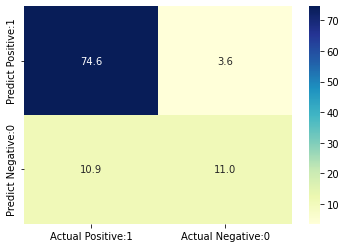

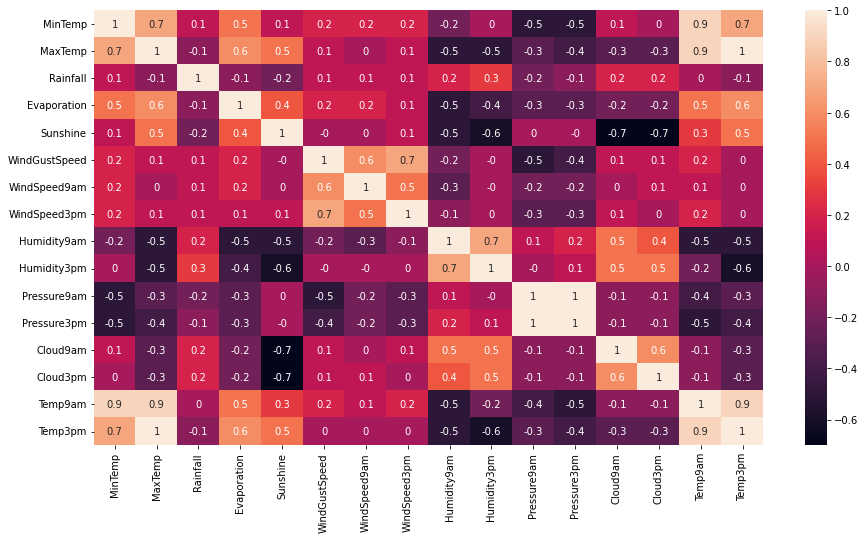

In [ ]:
cm = confusion_matrix(y_test,y_pred_test)
print('Confusion matrix\n\n', cm)

# print('\nTrue Positives(TP) = ', cm[0,0])

# print('\nTrue Negatives(TN) = ', cm[1,1])

# print('\nFalse Positives(FP) = ', cm[0,1])

# print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_percent = cm/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])*100
cm

plt.figure(figsize=(6,4))
cm_matrix = pd.DataFrame(data=cm_percent, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',fmt='.1f')
## Classification

#Ways of evaluating model performance
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
# Classification accuracy: 
# Sum of the true positive and true negative / total
print("Classification accuracy: {:.4f}".format((TP+TN)/float(TP+TN+FP+FN)))

# Classification error: incorrectly classified
print("Classification error: {:.4f}".format((FP+FN)/float(TP+TN+FP+FN)))
# Precision: Percentage of correctly predicted positive outcomes out of all predicted positive outcomes
print("Precision: {:.4f}".format((TP)/float(TP+FP)))

# Recall: Ration of all correctly predicted positive outcomes to all actual positive outcomes
print("Recall: {:.4f}".format((TP)/float(TP+FN)))
# Correlation matrix

df_original = pd.read_csv(url)
correlation_matrix = df_original.corr().round(1)
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

max_estimators = 1800
max_max_samples = 0.8
range_samples = np.arange(0.4,max_max_samples,0.2)
range_es = np.arange(1200,max_estimators,200)

n_est = len(range_es)
n_fracs = len(range_samples)

test_acc = np.zeros((n_est,n_fracs))
train_acc = np.zeros((n_est,n_fracs))

i = 0

for n_es in range_es:
  j = 0
  for sam in range_samples:
    Random_Forest_model = RandomForestClassifier(n_estimators=n_es, n_jobs=-1, random_state=1,max_features="auto",max_samples=sam)
    Random_Forest_model.fit(X_train, y_train)
    y_pred_test = Random_Forest_model.predict(X_test)
    y_pred_train = Random_Forest_model.predict(X_train)
    test_acc[i,j] = accuracy_score(y_test,y_pred_test)
    train_acc[i,j] = accuracy_score(y_train,y_pred_train)
    print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,sam,test_acc[i,j]))
    print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,sam,train_acc[i,j]))
    j+=1
  plt.figure(figsize=(5,4))
  plt.title("n_estimators = {}".format(n_es))
  plt.plot(range_samples,test_acc[i],label="test")
  plt.plot(range_samples,train_acc[i],label="train")
  plt.xlabel("Max samples")
  plt.legend()
  plt.show()
  i+=1

NameError: name 'X_train' is not defined

Best estimated parameters:
* n_estimators = 1200
* max_sample = 0.75



In [18]:
n_es = 800
sam = 0.75

Random_Forest_model = RandomForestClassifier(n_estimators=n_es, random_state=1,max_features="auto",max_samples=sam,min_samples_split=2,min_samples_leaf=5)
# Random_Forest_model.fit(X_train, y_train)
# y_pred_test = Random_Forest_model.predict(X_test)
# y_pred_train = Random_Forest_model.predict(X_train)
# test_acc = accuracy_score(y_test,y_pred_test)
# train_acc = accuracy_score(y_train,y_pred_train)
# print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,sam,test_acc))
# print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,sam,train_acc))


#Cross validation
Random_Forest_model.fit(X_train, y_train)
accuracy = cross_validate(Random_Forest_model,X_test,y_test,cv=5)['test_score']

print(accuracy)
print(accuracy.mean())

print("Test set accuracy with Random Forests and scaled data: {:.4f}".format(Random_Forest_model.score(X_test,y_test)))
print("Train set accuracy with Random Forests and scaled data: {:.4f}".format(Random_Forest_model.score(X_train,y_train)))

y_test_rf = Random_Forest_model.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_rf[:,1])


[0.8461935  0.84206908 0.84805775 0.84633895 0.84926091]
0.8463840404747998
Test set accuracy with Random Forests and scaled data: 0.8526


# Gradient Boosting

In [7]:
XGB_clf = xgb.XGBClassifier(max_depth=5,n_estimators=500)
XGB_clf.fit(X_train, y_train)
y_pred_test = XGB_clf.predict(X_test)
y_pred_train = XGB_clf.predict(X_train)
test_acc = accuracy_score(y_test,y_pred_test)
train_acc = accuracy_score(y_train,y_pred_train)
print("Model accuracy test score:{0:0.4f}".format(test_acc))
print("Model accuracy train score:{0:0.4f}".format(train_acc))

y_test_xgb = XGB_clf.predict_proba(X_test)
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_test_xgb[:,1])


Model accuracy test score:0.8611
Model accuracy train score:0.8863


Confusion matrix

 [[21572  1154]
 [ 2887  3479]]


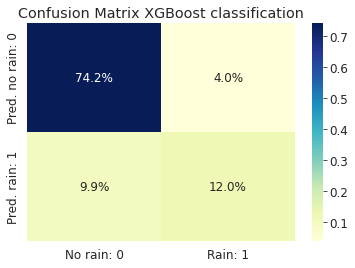

In [8]:
cm = confusion_matrix(y_test,y_pred_test)
print('Confusion matrix\n\n', cm)

# visualize confusion matrix with seaborn heatmap
cm_percent = cm/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
cm

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.title("Confusion Matrix XGBoost classification")
cm_matrix = pd.DataFrame(data=cm_percent, columns=['No rain: 0','Rain: 1'], 
                                 index=[ 'Pred. no rain: 0','Pred. rain: 1'])
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',fmt='.1%')

plt.savefig("cm_xgb.png",bbox_inches="tight")

### ROC Curve

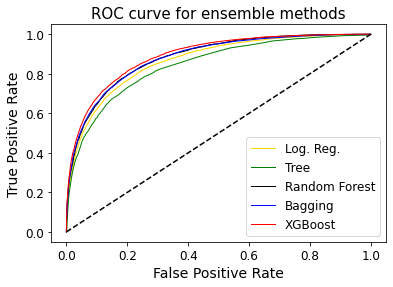

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.plot(fpr_lr,tpr_lr,'-',color="gold",linewidth=1,label="Log. Reg.")
plt.plot(fpr_tree,tpr_tree,'-g',linewidth=1,label="Tree")
plt.plot(fpr_rf,tpr_rf,"-",color="black",linewidth=1,label="Random Forest")
plt.plot(fpr_bag,tpr_bag,'-b',linewidth=1,label="Bagging")
plt.plot(fpr_xgb,tpr_xgb,'-r',linewidth=1,label="XGBoost")
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC curve for ensemble methods',fontsize=15)
plt.xlabel("False Positive Rate",fontsize=14)
plt.ylabel("True Positive Rate",fontsize=14)
plt.legend()
plt.savefig("ROC_ensemble.png",bbox_inches="tight")

# Neural Networks

In [2]:
# Loading our dataset 
url = 'https://raw.githubusercontent.com/engyssimo/MLProjectNucphys/main/Project2/Data/weatherAUS.csv'
data = pd.read_csv(url)

print(data.info())
print("----------------------------")
print(data.shape)

# Loading our dataset 
data["Date"] = pd.to_datetime(data["Date"])       # Change to datetime type so we can then divide into year , month and day
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data.drop("Date",axis=1,inplace=True)
data.head()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## Repeat the preprocessing

### A. Categorical features:  Replace missing values by common and encoding

In [5]:
# categorical feature
cat_feature = [i for i in data.columns if data[i].dtype=='O']
data[cat_feature].head()

Location WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
0   Albury           W          W        WNW        No           No
1   Albury         WNW        NNW        WSW        No           No
2   Albury         WSW          W        WSW        No           No
3   Albury          NE         SE          E        No           No
4   Albury           W        ENE         NW        No           No

In [6]:
for col in cat_feature:
    if data[col].isnull().sum() !=0 : 
        common = data[col].mode()[0]         # returns the most frequent value 
        data[col] = data[col].fillna(common)
        

### B: Model


In [8]:
from tensorflow.keras.layers import Dense , Activation, Dropout, Conv1D, Reshape, BatchNormalization as BN
import tensorflow as tf

def train_model(model, name, train_data, val_data, batch_size=100, epochs=30):
    def lr_scheduler(epochs):
        if epochs < 10:
            return 1e-3
        else:
            if epochs < 20:
                return 1e-4
            else:
                return 1e-5

    filepath =  './models/' + name + '.hdf5'
    saving = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                 save_weights_only=True)
    history = model.fit(
    train_data[0], train_data[1],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_data,
    verbose=2,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), saving]
    )   

    return None


def fully_dense_model(num_features, train_data, val_data, 
                      units, activation, rate):
    inputs = tf.keras.layers.Input(shape=(num_features,))
    x = Dense(4*units, activation=activation)(inputs)
    x = BN()(x)
    x = Dropout(rate)(x)
    x = Dense(2*units, activation=activation)(x)
    x = BN()(x)
    x = Dropout(rate)(x)
    x = Dense(units, activation=activation)(x)
    x = BN()(x)
    x = Dropout(rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    name = 'fully_dense_num-features=' + str(num_features)
    file_path = './models/' + name + '.hdf5'
    train_model(model, name, train_data, val_data)
    model.load_weights(file_path)
    
    return model






### C: Encoding

In [9]:
df = data.copy()
df.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0   Albury     13.4     22.9       0.6          NaN       NaN           W   
1   Albury      7.4     25.1       0.0          NaN       NaN         WNW   
2   Albury     12.9     25.7       0.0          NaN       NaN         WSW   
3   Albury      9.2     28.0       0.0          NaN       NaN          NE   
4   Albury     17.5     32.3       1.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  Pressure3pm  Cloud9am  Cloud3pm  \
0           44.0          W        WNW  ...       1007.1       8.0       NaN   
1           44.0        NNW        WSW  ...       1007.8       NaN       NaN   
2           46.0          W        WSW  ...       1008.7       NaN       2.0   
3           24.0         SE          E  ...       1012.8       NaN       NaN   
4           41.0        ENE         NW  ...       1006.0       7.0       8.0   

   Temp9am  Temp3pm  RainToday  RainTomorrow  Year  Month  Day  
0     16.9     21.8         No            No  2008     12    1  
1     17.2     24.3         No            No  2008     12    2  
2     21.0     23.2         No            No  2008     12    3  
3     18.1     26.5         No            No  2008     12    4  
4     17.8     29.7         No            No  2008     12    5  

[5 rows x 25 columns]

### D: Handle NaN values: replaced by median values 
This part should be seperated between train and test set

In [10]:
from sklearn.impute import SimpleImputer
nan_col = [i for i in df.columns if df[i].isnull().sum() != 0 ]

In [11]:
def handle_nan(X_train, X_test, method = 'median'):
    global nan_col,df
    imputer = SimpleImputer(missing_values=np.nan, strategy= method)
    for col in  nan_col:
        X_train[[col]] = imputer.fit_transform(X_train[[col]])
        X_test[[col]] = imputer.fit_transform(X_test[[col]])
    return X_train,X_test

 ### One - hot encoding

In [15]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl.fit(list(df["RainTomorrow"].values))
df["RainTomorrow"] = lbl.transform(df["RainTomorrow"].values)

for col in cat_feature[:-1]:
    buffer = pd.get_dummies(df[col])
    df = pd.concat([df,buffer], axis = 1)
    df= df.drop(columns = col)


df.head()

In [17]:
#Excluding the outliers

features_with_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for feature in features_with_outliers:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature]<lower_limit,feature] = lower_limit
    df.loc[df[feature]>upper_limit,feature] = upper_limit

In [19]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=0)
X_train = df_train.drop(["RainTomorrow"], axis=1)
y_train = df_train.RainTomorrow
X_test = df_test.drop(["RainTomorrow"], axis=1)
y_test = df_test.RainTomorrow

X_train,X_test = handle_nan(X_train, X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_test = scaler.transform(X_test)

num_features = X_train.shape[1]


In [20]:
best_function= None
best_unit = None
best_accuracy = 0
best_drop_rate = None

units = [64,128]
functions = ['relu', 'tanh', 'sigmoid']
drop = [0.05, 0.1]
for drop_rate in drop:

    f= open( str(drop_rate) +".txt","w+")
    for unit in units:
        for func in functions:
            f.write(' unit, activation function, features , train accuracy, test accuracy \n' )
            
            model = fully_dense_model(num_features, (X_train,y_train), (X_test, y_test), units = unit, activation = func, rate = drop_rate)
            loss, test_accuracy = model.evaluate(X_test,y_test)
            _, train_accuracy = model.evaluate(X_train, y_train)
            string = str(unit) + ' ' + func+ ' ' +str(num_features)+' '+str(train_accuracy)+ ' '+str(test_accuracy)+'\n'
            f.write(string)

            if best_accuracy < test_accuracy:
                best_accuracy = test_accuracy
                best_unit = unit
                best_function = func
                best_drop_rate = drop_rate
    f.close()

print('best accuracy: ', best_accuracy, 'best unit', best_unit, 'best function', best_function, 'best drop rate', best_drop_rate)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118)]             0         
                                                                 
 dense (Dense)               (None, 256)               30464     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                             

Epoch 1/30
1164/1164 - 5s - loss: 0.3826 - accuracy: 0.8320 - val_loss: 0.3438 - val_accuracy: 0.8526 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 2/30
1164/1164 - 4s - loss: 0.3421 - accuracy: 0.8524 - val_loss: 0.3395 - val_accuracy: 0.8533 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 3/30
1164/1164 - 4s - loss: 0.3324 - accuracy: 0.8564 - val_loss: 0.3379 - val_accuracy: 0.8538 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 4/30
1164/1164 - 4s - loss: 0.3242 - accuracy: 0.8607 - val_loss: 0.3322 - val_accuracy: 0.8584 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 5/30
1164/1164 - 4s - loss: 0.3185 - accuracy: 0.8630 - val_loss: 0.3319 - val_accuracy: 0.8579 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 6/30
1164/1164 - 6s - loss: 0.3133 - accuracy: 0.8655 - val_loss: 0.3310 - val_accuracy: 0.8592 - lr: 0.0010 - 6s/epoch - 5ms/step
Epoch 7/30
1164/1164 - 4s - loss: 0.3062 - accuracy: 0.8686 - val_loss: 0.3312 - val_accuracy: 0.8586 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 8/30
1164/1164 - 4s - loss: 0.3008 

Epoch 14/30
1164/1164 - 4s - loss: 0.2816 - accuracy: 0.8793 - val_loss: 0.3255 - val_accuracy: 0.8629 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 15/30
1164/1164 - 4s - loss: 0.2796 - accuracy: 0.8806 - val_loss: 0.3265 - val_accuracy: 0.8623 - lr: 1.0000e-04 - 4s/epoch - 4ms/step
Epoch 16/30
1164/1164 - 7s - loss: 0.2789 - accuracy: 0.8813 - val_loss: 0.3272 - val_accuracy: 0.8617 - lr: 1.0000e-04 - 7s/epoch - 6ms/step
Epoch 17/30
1164/1164 - 4s - loss: 0.2772 - accuracy: 0.8820 - val_loss: 0.3281 - val_accuracy: 0.8610 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 18/30
1164/1164 - 4s - loss: 0.2771 - accuracy: 0.8815 - val_loss: 0.3286 - val_accuracy: 0.8611 - lr: 1.0000e-04 - 4s/epoch - 4ms/step
Epoch 19/30
1164/1164 - 4s - loss: 0.2755 - accuracy: 0.8822 - val_loss: 0.3295 - val_accuracy: 0.8611 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 20/30
1164/1164 - 4s - loss: 0.2750 - accuracy: 0.8827 - val_loss: 0.3293 - val_accuracy: 0.8602 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 

Epoch 27/30
1164/1164 - 5s - loss: 0.1552 - accuracy: 0.9357 - val_loss: 0.4547 - val_accuracy: 0.8453 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
Epoch 28/30
1164/1164 - 6s - loss: 0.1542 - accuracy: 0.9356 - val_loss: 0.4553 - val_accuracy: 0.8454 - lr: 1.0000e-05 - 6s/epoch - 5ms/step
Epoch 29/30
1164/1164 - 5s - loss: 0.1545 - accuracy: 0.9364 - val_loss: 0.4573 - val_accuracy: 0.8451 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
Epoch 30/30
1164/1164 - 5s - loss: 0.1536 - accuracy: 0.9365 - val_loss: 0.4583 - val_accuracy: 0.8456 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
3637/3637 [==============================] - 5s 1ms/step - loss: 0.2890 - accuracy: 0.8747
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 118)]             0         
                                                                 
 dense_16 (Dense)            (None, 512)               60928

Epoch 1/30
1164/1164 - 6s - loss: 0.3774 - accuracy: 0.8353 - val_loss: 0.3439 - val_accuracy: 0.8520 - lr: 0.0010 - 6s/epoch - 5ms/step
Epoch 2/30
1164/1164 - 5s - loss: 0.3423 - accuracy: 0.8526 - val_loss: 0.3413 - val_accuracy: 0.8515 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 3/30
1164/1164 - 5s - loss: 0.3340 - accuracy: 0.8559 - val_loss: 0.3323 - val_accuracy: 0.8560 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 4/30
1164/1164 - 5s - loss: 0.3287 - accuracy: 0.8593 - val_loss: 0.3303 - val_accuracy: 0.8579 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 5/30
1164/1164 - 5s - loss: 0.3225 - accuracy: 0.8612 - val_loss: 0.3348 - val_accuracy: 0.8555 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 6/30
1164/1164 - 5s - loss: 0.3180 - accuracy: 0.8632 - val_loss: 0.3294 - val_accuracy: 0.8574 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 7/30
1164/1164 - 5s - loss: 0.3117 - accuracy: 0.8660 - val_loss: 0.3302 - val_accuracy: 0.8579 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 8/30
1164/1164 - 5s - loss: 0.3067 

Epoch 14/30
1164/1164 - 4s - loss: 0.2658 - accuracy: 0.8850 - val_loss: 0.3306 - val_accuracy: 0.8609 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 15/30
1164/1164 - 4s - loss: 0.2637 - accuracy: 0.8857 - val_loss: 0.3332 - val_accuracy: 0.8614 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 16/30
1164/1164 - 4s - loss: 0.2613 - accuracy: 0.8867 - val_loss: 0.3353 - val_accuracy: 0.8605 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 17/30
1164/1164 - 4s - loss: 0.2608 - accuracy: 0.8875 - val_loss: 0.3360 - val_accuracy: 0.8605 - lr: 1.0000e-04 - 4s/epoch - 4ms/step
Epoch 18/30
1164/1164 - 8s - loss: 0.2592 - accuracy: 0.8875 - val_loss: 0.3370 - val_accuracy: 0.8597 - lr: 1.0000e-04 - 8s/epoch - 7ms/step
Epoch 19/30
1164/1164 - 4s - loss: 0.2573 - accuracy: 0.8883 - val_loss: 0.3391 - val_accuracy: 0.8592 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 20/30
1164/1164 - 4s - loss: 0.2559 - accuracy: 0.8898 - val_loss: 0.3403 - val_accuracy: 0.8587 - lr: 1.0000e-04 - 4s/epoch - 4ms/step
Epoch 

Epoch 27/30
1164/1164 - 4s - loss: 0.2659 - accuracy: 0.8867 - val_loss: 0.3353 - val_accuracy: 0.8582 - lr: 1.0000e-05 - 4s/epoch - 3ms/step
Epoch 28/30
1164/1164 - 4s - loss: 0.2649 - accuracy: 0.8882 - val_loss: 0.3353 - val_accuracy: 0.8579 - lr: 1.0000e-05 - 4s/epoch - 3ms/step
Epoch 29/30
1164/1164 - 4s - loss: 0.2664 - accuracy: 0.8861 - val_loss: 0.3354 - val_accuracy: 0.8581 - lr: 1.0000e-05 - 4s/epoch - 3ms/step
Epoch 30/30
1164/1164 - 4s - loss: 0.2674 - accuracy: 0.8863 - val_loss: 0.3359 - val_accuracy: 0.8582 - lr: 1.0000e-05 - 4s/epoch - 4ms/step
3637/3637 [==============================] - 4s 888us/step - loss: 0.2621 - accuracy: 0.8896
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 118)]             0         
                                                                 
 dense_32 (Dense)            (None, 256)               304

_________________________________________________________________
Epoch 1/30
1164/1164 - 6s - loss: 0.3781 - accuracy: 0.8355 - val_loss: 0.3341 - val_accuracy: 0.8550 - lr: 0.0010 - 6s/epoch - 5ms/step
Epoch 2/30
1164/1164 - 5s - loss: 0.3329 - accuracy: 0.8558 - val_loss: 0.3288 - val_accuracy: 0.8580 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 3/30
1164/1164 - 5s - loss: 0.3235 - accuracy: 0.8609 - val_loss: 0.3276 - val_accuracy: 0.8581 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 4/30
1164/1164 - 5s - loss: 0.3164 - accuracy: 0.8635 - val_loss: 0.3264 - val_accuracy: 0.8605 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 5/30
1164/1164 - 5s - loss: 0.3109 - accuracy: 0.8655 - val_loss: 0.3247 - val_accuracy: 0.8593 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 6/30
1164/1164 - 5s - loss: 0.3043 - accuracy: 0.8671 - val_loss: 0.3249 - val_accuracy: 0.8614 - lr: 0.0010 - 5s/epoch - 4ms/step
Epoch 7/30
1164/1164 - 5s - loss: 0.2985 - accuracy: 0.8700 - val_loss: 0.3238 - val_accuracy: 0.8623 - lr: 0.00

1164/1164 - 6s - loss: 0.2663 - accuracy: 0.8854 - val_loss: 0.3340 - val_accuracy: 0.8603 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 14/30
1164/1164 - 5s - loss: 0.2619 - accuracy: 0.8879 - val_loss: 0.3361 - val_accuracy: 0.8603 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 15/30
1164/1164 - 5s - loss: 0.2595 - accuracy: 0.8891 - val_loss: 0.3390 - val_accuracy: 0.8585 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 16/30
1164/1164 - 5s - loss: 0.2560 - accuracy: 0.8911 - val_loss: 0.3403 - val_accuracy: 0.8583 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 17/30
1164/1164 - 5s - loss: 0.2546 - accuracy: 0.8916 - val_loss: 0.3419 - val_accuracy: 0.8583 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 18/30
1164/1164 - 5s - loss: 0.2511 - accuracy: 0.8932 - val_loss: 0.3442 - val_accuracy: 0.8576 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 19/30
1164/1164 - 5s - loss: 0.2496 - accuracy: 0.8934 - val_loss: 0.3454 - val_accuracy: 0.8572 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 20/30
1164/1

Epoch 26/30
1164/1164 - 5s - loss: 0.2603 - accuracy: 0.8888 - val_loss: 0.3340 - val_accuracy: 0.8604 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
Epoch 27/30
1164/1164 - 5s - loss: 0.2608 - accuracy: 0.8886 - val_loss: 0.3346 - val_accuracy: 0.8607 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
Epoch 28/30
1164/1164 - 5s - loss: 0.2609 - accuracy: 0.8889 - val_loss: 0.3347 - val_accuracy: 0.8604 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
Epoch 29/30
1164/1164 - 5s - loss: 0.2597 - accuracy: 0.8889 - val_loss: 0.3347 - val_accuracy: 0.8604 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
Epoch 30/30
1164/1164 - 5s - loss: 0.2590 - accuracy: 0.8889 - val_loss: 0.3351 - val_accuracy: 0.8603 - lr: 1.0000e-05 - 5s/epoch - 4ms/step
3637/3637 [==============================] - 6s 2ms/step - loss: 0.2553 - accuracy: 0.8913


In [12]:
#train the model

model = fully_dense_model(num_features, (X_train,y_train), (X_test, y_test), units =  best_unit, activation = best_function, rate = best_drop_rate )
loss, test_accuracy = model.evaluate(X_test,y_test)
_, train_accuracy = model.evaluate(X_train, y_train)


print(' unit, activation function, features , train accuracy, test accuracy \n' )
string = str(best_unit) + ' ' + best_function+ ' ' +str(num_features)+' '+str(train_accuracy)+ ' '+str(test_accuracy)+'\n'
print(string)

NameError: name 'fully_dense_model' is not defined

Confusion matrix

 [[21439  1287]
 [ 2682  3684]]


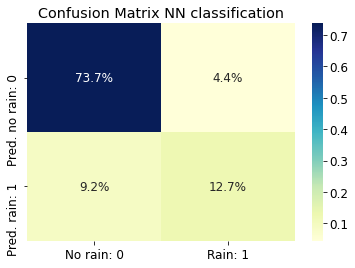

In [32]:
from sklearn.metrics import confusion_matrix
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix\n\n', cm)

# visualize confusion matrix with seaborn heatmap
cm_percent = cm/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.title("Confusion Matrix NN classification")
cm_matrix = pd.DataFrame(data=cm_percent, columns=['No rain: 0','Rain: 1'], 
                                 index=[ 'Pred. no rain: 0','Pred. rain: 1'])

sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',fmt='.1%')

plt.savefig("cm_xgb.png",bbox_inches="tight")